# Forecasting: ARIMA – SARIMA – SARIMAX

In this notebook, we explore three powerful models for time series forecasting: **ARIMA**, **SARIMA**, and **SARIMAX**.

- **ARIMA (AutoRegressive Integrated Moving Average)** is a model that combines:
  - Autoregression (AR): using past values
  - Integration (I): differencing to make the series stationary
  - Moving Average (MA): using past forecast errors

  The general formula is:

  $$
  Y_t = c + \phi_1 Y_{t-1} + \dots + \phi_p Y_{t-p} + \theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q} + \varepsilon_t
  $$

- **SARIMA (Seasonal ARIMA)** extends ARIMA by adding seasonal components. It is useful when the data shows regular seasonal patterns.

  The model is noted as **ARIMA(p, d, q)(P, D, Q)\_s**, where `s` is the seasonality period.

  $$ 
  \Phi_P(L^s)\phi_p(L)(1 - L)^d (1 - L^s)^D Y_t = \Theta_Q(L^s)\theta_q(L) \varepsilon_t
  $$

- **SARIMAX (SARIMA with eXogenous variables)** is an advanced version of SARIMA that includes external features (also called exogenous variables). These features can help improve forecast accuracy.

  The formula is:

  $$
  Y_t = SARIMA\ terms + \beta X_t
  $$

Each model builds on the previous one to capture more complex patterns in the time series.


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('nyc_data.csv', index_col = 0, parse_dates = True).rename(columns = {'Date': 'ds', 'Demand': 'y'})
data.head()

,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2015-01-01,720.000885,0,0,0,3.68,41.305
2015-01-02,581.276773,0,0,0,4.73,131.574
2015-01-03,754.117039,0,0,0,7.23,162.700
2015-01-04,622.252774,0,0,0,10.96,160.281
2015-01-05,785.373319,0,0,0,6.92,51.077


In [4]:
# Extract Regressor
X = data[['Easter', 'Thanksgiving', 'Christmas', 'Temperature', 'Marketing']]


### Stationarity

**Important**
Dans le test de Dickey-Fuller:
* H₀ (hypothèse nulle) = la série n’est pas stationnaire (elle a une racine unitaire)
* H₁ (hypothèse alternative) = la série est stationnaire

In [5]:
from statsmodels.tsa.stattools import adfuller

def add_fuller_test(data):
    ''' 
    Using Dickey-Fuller test to check stationarity
    '''

    fuller_test = adfuller(x = data)

    p_value = fuller_test[1]
    critical_value_5pct = fuller_test[4]['5%']
    statistic = fuller_test[0]

    if critical_value_5pct > statistic:
        print('The series is stationary (reject H0)')
    else:
        print('The series is NOT stationary (fail to reject H0)')

original_data_test = add_fuller_test(data = data.y)
original_data_test

The series is NOT stationary (fail to reject H0)


In [6]:
## Differencing
diff_data = data.y.diff().dropna()
diff_data_test = add_fuller_test(diff_data)
diff_data_test

The series is stationary (reject H0)


### Moving Average Componant (MA)

**Past error lag, contains informations that help predict future values**

#### Parameters

* p - Order of AutoRegressive : Number of time series lag used
* d - Degree of first differenciation involved : Number of differienciation 
* q - Order of Moving Average part : Number of forecasting erros lags used  

**Important:** (p, d, q) are non-negative values  

In [7]:
import pmdarima as pm 

# p - Nombre de valeurs passées à utiliser (AutoRegressive)
# d - Nombre de différenciations pour stationnariser la série
# q - Nombre d’erreurs passées à utiliser (Moving Average) 
# hourly: 24, day: 7, weekly: 52, monhtly: 12, quarter: 4

model = pm.ARIMA(order = (1, 1, 1), # (p, d, q)
                seasonal_order = (1, 1, 1, 7), # version saisonnière d’ARIMA, SARIMA (p, d, q, s) - 7 : tenir compte d'un cycle qui revient tous les 7 jours  
                X = X,
                suppress_warnings = True)
model

ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), suppress_warnings=True)

### Cross-Validation

`RollingForecastCV` simule plusieurs prévisions dans le passé pour voir si ton modèle aurait bien prédit.

In [8]:
from pmdarima import model_selection

cv = model_selection.RollingForecastCV(h = 31,                                          # prédiction de 31 jours à chaque fois
                                       step = 16,                                       # on avance de 16 jours à chaque boucle
                                       initial = 2012)                                  # on commence avec 2012 jours pour la 1ère prédiction

cv_model =  model_selection.cross_val_score(estimator = model,                          # le modèle ARIMA qu'on veut tester
                                            y = diff_data,
                                            scoring = 'mean_squared_error',
                                            cv = cv,                                    # stratégie de validation (rolling)
                                            verbose = 2)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................


In [9]:
# array of all mse
error = np.sqrt(np.mean(cv_model))
error

61.584591779993836

### Parameters Tuning

In [13]:
from sklearn.model_selection import ParameterGrid

params = {'p': [0, 1], 'd': [1], 'q': [0, 1], 'P': [0, 1], 'D': [1], 'Q': [0, 1]}
grid = ParameterGrid(param_grid = params)
print(f'Lenght of all grid: {len(list(grid))}')

Lenght of all grid: 16


In [ ]:
MAE = {}
i = 0

for params in grid:
    print(f'{i + 1} / {len(grid)}')
    print(params)
    model = pm.ARIMA(order = (params['p'], params['d'], params['q']),
                seasonal_order = (params['P'], params['D'], params['Q'], 7), 
                X = X,
                suppress_warnings = True)
    
    cv = model_selection.RollingForecastCV(h = 31,                                    
                                       step = 16,                                   
                                       initial = 2012)                              

    cv_model =  model_selection.cross_val_score(estimator = model,                        
                                                y = diff_data,
                                                scoring = 'mean_squared_error',
                                                cv = cv,                               
                                                verbose = 1)
    # array of all mse
    error = np.sqrt(np.mean(cv_model))
    MAE[error] = params
    i += 1

0 / 16
1 / 16
2 / 16
3 / 16
4 / 16
5 / 16
6 / 16
7 / 16
8 / 16
9 / 16
10 / 16
11 / 16
12 / 16
13 / 16
14 / 16
15 / 16


In [23]:
min_mse = min(list(MAE.keys()))
MAE.get(min_mse)

{'D': 1, 'P': 0, 'Q': 1, 'd': 1, 'p': 1, 'q': 1}

## Forecasting

In [36]:
data = pd.read_csv('nyc_data.csv', index_col = 0, parse_dates = True).rename(columns = {'Date': 'ds', 'Demand': 'y'})
future_data = pd.read_csv('future.csv', index_col = 0, parse_dates = True)

train_X = data[['Easter', 'Thanksgiving', 'Christmas', 'Temperature', 'Marketing']]
future_X = future_data.iloc[:, 1:]

In [37]:
min_mse = min(list(MAE.keys()))
best_parameters = MAE.get(min_mse)

model = pm.ARIMA(order = (best_parameters['p'], best_parameters['d'], best_parameters['q']),
            seasonal_order = (best_parameters['P'], best_parameters['D'], best_parameters['Q'], 7), 
            X = train_X,
            suppress_warnings = True)
model.fit(data.y)

ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 7), suppress_warnings=True)

In [40]:
# Prdiction 
predictions = model.predict(n_periods = len(future_X),
               X = future_X).rename('Sarimax')
predictions.values

array([740.6664676 , 853.009185  , 772.64346061, 902.34483286,
       775.89763381, 931.34702286, 824.49392446, 738.53115025,
       853.69634214, 773.1443014 , 902.85805744, 776.41012006,
       931.85963735, 825.00660996, 739.04391055, 854.20917698,
       773.65721081, 903.37104142, 776.92317859, 932.37277045,
       825.51981762, 739.55719277, 854.72253377, 774.17064215,
       903.88454732, 777.43675906, 932.88642548, 826.03354721,
       740.07099692, 855.23641248, 774.68459543])

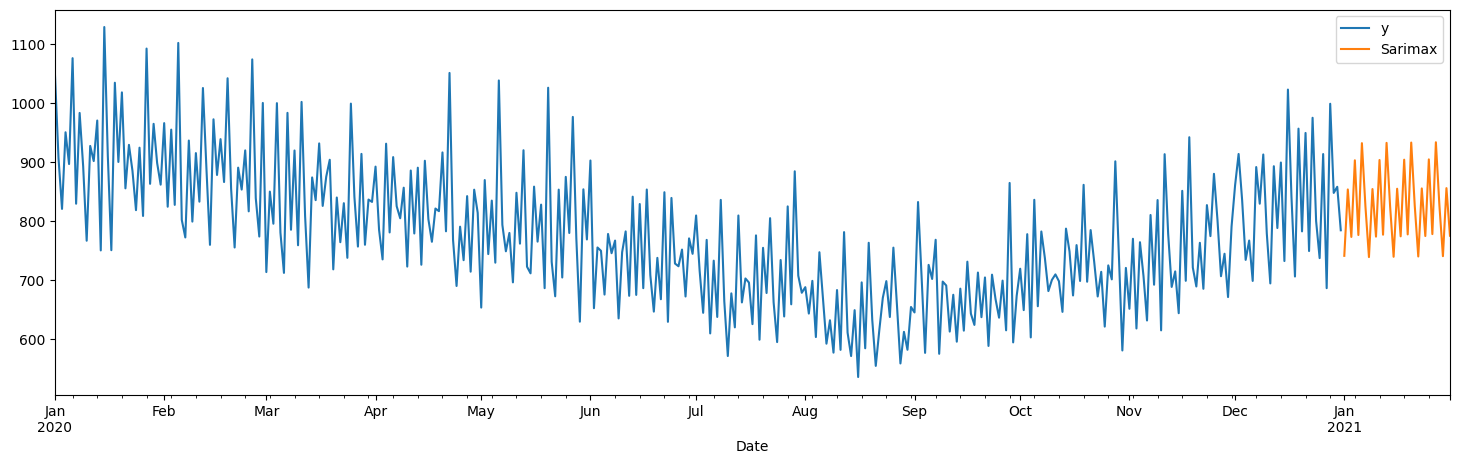

In [44]:
# Visualize data
data.y['2020-01-01': ].plot(figsize = (18, 5), legend = True)
predictions.plot(legend = True)
plt.show()